In [1]:
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from keras.utils.vis_utils import plot_model
from keras_radam import RAdam

from helpers import*

Using TensorFlow backend.


## Loading the dataset 

In [2]:
data = pd.read_csv('datasets/bank-additional.csv', sep=';')

# Neural Network

In [7]:
def run_benchmark(data, activation = 'selu', N_spec = 30):
    list_optimzers = ['adam', 'sgd', RAdam()]
    spects = np.linspace(0.5,0.99,N_spec)
    
    sgd_f1 = []
    adam_f1 = []
    radam_f1 = []
    
    sgd_precision = []
    adam_precision = []
    radam_precision = []
    
    sgd_recall = []
    adam_recall = []
    radam_recall = []
    
    for spect in spects:
        one_hot_enc = build_spectrum (data,do_spectrum = True ,spect = spect)
        X = one_hot_enc.drop(columns=['y'])
        y = one_hot_enc['y']
        x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
        x_train_keras, y_train_keras = build_keras (x_train,y_train)
        model = build_model(activation)
        for l in list_optimzers:
            model.compile(loss='binary_crossentropy', optimizer=l, metrics=[f1_m,precision_m, recall_m])
            model.fit(np.array(x_train_keras), np.array(y_train_keras), epochs=50, batch_size=128, shuffle=True, verbose=0)
            loss, f1_score, precision, recall = model.evaluate(np.array(x_test), np.array(y_test),verbose = 0)
            
            if l == 'adam':
                adam_f1.append(f1_score)
                adam_precision.append(precision)
                adam_recall.append(recall)
                
            elif l == 'sgd':
                sgd_f1.append(f1_score)
                sgd_precision.append(precision)
                sgd_recall.append(recall)
            else:
                radam_f1.append(f1_score)
                radam_precision.append(precision)
                radam_recall.append(recall)
    return spects, sgd_f1, sgd_precision, sgd_recall, adam_f1, adam_precision, adam_recall, radam_f1, radam_precision, radam_recall

# Results


**SELU activation**

In [23]:
spects, sgd_f1, sgd_precision, sgd_recall, adam_f1, adam_precision, adam_recall, radam_f1, radam_precision, radam_recall = run_benchmark(data, N_spec=10)

Fraction of No :
0.9900221729490022
Fraction of Yes :
0.009977827050997782


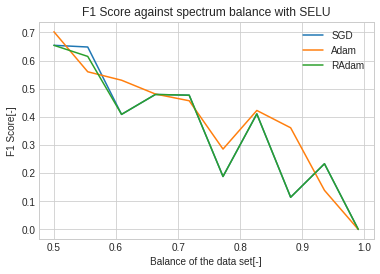

In [26]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_f1, label='SGD')
plt.plot(spects, adam_f1, label='Adam')
plt.plot(spects, radam_f1, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('F1 Score[-]')
plt.title('F1 Score against spectrum balance with SELU')
plt.legend(loc='upper right')
plt.savefig('figures/f1-spect-SELU.png')

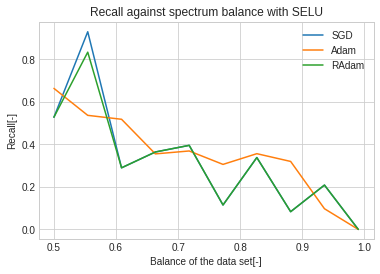

In [27]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_recall, label='SGD')
plt.plot(spects, adam_recall, label='Adam')
plt.plot(spects, radam_recall, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Recall[-]')
plt.title('Recall against spectrum balance with SELU')
plt.legend(loc='upper right')
plt.savefig('figures/recall-spect-SELU.png')

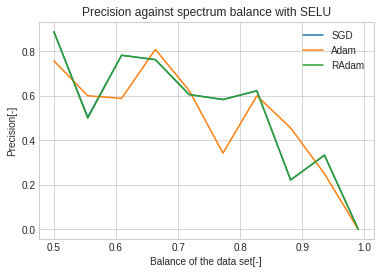

In [28]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_precision, label='SGD')
plt.plot(spects, adam_precision, label='Adam')
plt.plot(spects, radam_precision, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Precision[-]')
plt.title('Precision against spectrum balance with SELU')
plt.legend(loc='upper right')
plt.savefig('figures/precision-spect-SELU.png')

**Tanh activation**

In [29]:
spects, sgd_f1, sgd_precision, sgd_recall, adam_f1, adam_precision, adam_recall, radam_f1, radam_precision, radam_recall = run_benchmark(data, activation = 'tanh', N_spec=10)

Fraction of No :
0.9900221729490022
Fraction of Yes :
0.009977827050997782


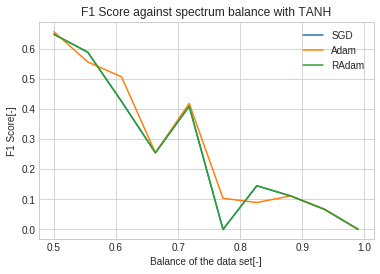

In [30]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_f1, label='SGD')
plt.plot(spects, adam_f1, label='Adam')
plt.plot(spects, radam_f1, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('F1 Score[-]')
plt.title('F1 Score against spectrum balance with TANH')
plt.legend(loc='upper right')
plt.savefig('figures/f1-spect-TANH.png')

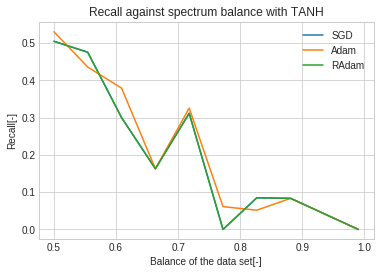

In [31]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_recall, label='SGD')
plt.plot(spects, adam_recall, label='Adam')
plt.plot(spects, radam_recall, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.title('Recall against spectrum balance with TANH')
plt.ylabel('Recall[-]')
plt.legend(loc='upper right')
plt.savefig('figures/recall-spect-TANH.png')

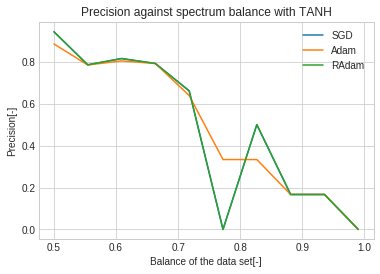

In [32]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_precision, label='SGD')
plt.plot(spects, adam_precision, label='Adam')
plt.plot(spects, radam_precision, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Precision[-]')
plt.title('Precision against spectrum balance with TANH')
plt.legend(loc='upper right')
plt.savefig('figures/precision-spect-TANH.png')

# Training and test effect

In [34]:
def run_training_benchmarking(data, epochs = 50):
    list_optimzers = ['adam', 'sgd', RAdam()]
    
    adam_val_loss = []
    radam_val_loss = []
    sgd_val_loss = []
    
    
    one_hot_enc = build_spectrum (data)

    X = one_hot_enc.drop(columns=['y'])
    y = one_hot_enc['y']
    x_keras, y_keras = build_keras (X,y)

    model = build_model(activation='selu')
    for l in list_optimzers:
        model.compile(loss='binary_crossentropy', optimizer=l, metrics=['accuracy'])
        history = model.fit(np.array(x_keras), np.array(y_keras), 
                    epochs=epochs, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose = 0)

        if l == 'adam':
            adam_val_loss.append(history.history['val_loss'])

        elif l == 'sgd':
            sgd_val_loss.append(history.history['val_loss'])
        else:
            radam_val_loss.append(history.history['val_loss'])
    return sgd_val_loss, radam_val_loss,adam_val_loss
                

In [35]:
sgd_val_loss, radam_val_loss, adam_val_loss = run_training_benchmarking(data)

Fraction of No :
0.890507404709881
Fraction of Yes :
0.10949259529011895


# Results

In [37]:
adam_val_loss

[[16.550606441220665,
  17.229630084919688,
  17.848389729076164,
  18.269982684900402,
  18.58383066462846,
  18.82825812380638,
  19.10697375910897,
  19.306157374831617,
  19.445357451411237,
  19.66695380545913,
  19.812085835801803,
  19.941863284974406,
  20.091694142107407,
  20.194909571820812,
  20.346864438993595,
  20.473109544362796,
  20.565989695886618,
  20.707910049549717,
  20.79109025685033,
  20.89628914535287,
  21.015197856703185,
  21.11929792316349,
  21.176020625228933,
  21.29084587459396,
  21.39748160012982,
  21.474229802951008,
  21.570018384683657,
  21.64350868200098,
  21.763541237889196,
  21.839316370631526,
  21.90328752207763,
  22.009152074229988,
  22.119302404615425,
  22.15742289358883,
  22.272916549957092,
  22.382282923904306,
  22.43442124058156,
  22.547707686922767,
  22.64963260524466,
  22.73510707784726,
  22.830750789924256,
  22.912709194406965,
  22.99621139891229,
  23.109064622236996,
  23.17615131066535,
  23.266190875471672,
  23.

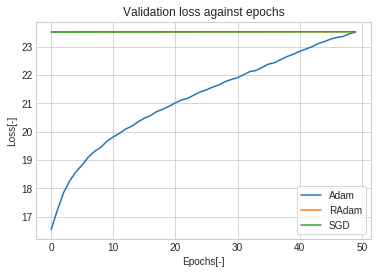

In [41]:
plt.style.use('seaborn-whitegrid')
plt.plot(adam_val_loss[0], label='Adam')
plt.plot(radam_val_loss[0], label='RAdam')
plt.plot(sgd_val_loss[0], label='SGD')
plt.xlabel('Epochs[-]')
plt.ylabel('Loss[-]')
plt.title('Validation loss against epochs')
plt.legend(loc='lower right', frameon = True)
plt.savefig('figures/loss-epochs.png')